  ## Name - Humza Khan, Student ID: 040008336 , Neural Network Cw

## Comparision between MLP and SVM Model on MNIST dataset

In [91]:
# !conda install torchvision -c pytorch

Importing libraries into the notebook

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,make_scorer,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score,plot_confusion_matrix, roc_curve,plot_roc_curve
from sklearn import svm, datasets
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_predict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn # to load all neural net functionality
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import Dataset, DataLoader  # lets us load data in batches
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter 
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
import os
import pickle
import time
from sklearn.model_selection import cross_val_score

In [4]:
#loading the train dataset from datasets library 
mnist_train_set = datasets.MNIST(root='', train=True, download=True, transform=transforms.ToTensor())
mnist_train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
#loading the test dataset from datasets library 
mnist_test_set = datasets.MNIST(root='', train=False, download=False, transform=transforms.ToTensor())
mnist_test_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [95]:
len(mnist_train_set)

60000

In [96]:
len(mnist_test_set)

10000

The train data has 60,000 images and test has 10,000. 

EDA and PRE-PROCESSING

In [97]:
type(mnist_train_set) #checking the datatype for train set

torchvision.datasets.mnist.MNIST

In [98]:
image, label = mnist_train_set[0]
print('Shape:', image.shape, '\nLabel:', label) #checking the shape of the train set

Shape: torch.Size([1, 28, 28]) 
Label: 5


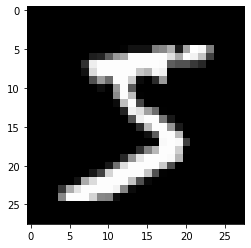

In [99]:
plt.imshow(image.reshape((28,28)), cmap="gray") #plotting and visualizing a digit from train set

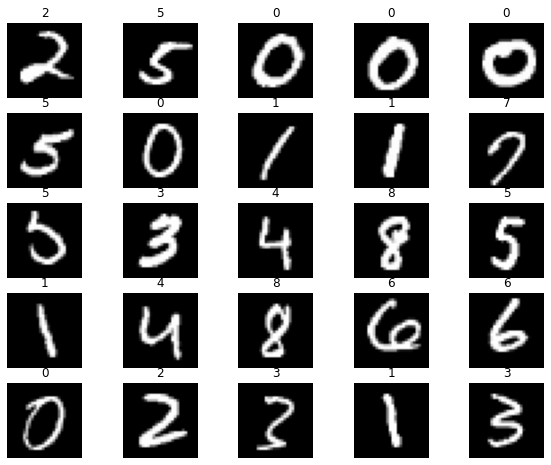

In [100]:
#plotting the different digits from the train set
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train_set), size=(1,)).item()
    img, label = mnist_train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Splitting the train and test data into input features and the output labels 

In [6]:
train = mnist_train_set.data #input class in train set
test = mnist_test_set.data #input class in test set
trainlab = mnist_train_set.targets #outplut class in train set
testlab = mnist_test_set.targets #outplut class in test set

In [7]:
seq = np.random.randint(0,60000,6000) #randomly generating seq for getting X_train and Y_train samples
train_samp = train[seq] #getting input data from train set - X_train
trainlab_samp = trainlab[seq] #getting output data from train set - Y_train
print("shape of input data from train set : ",train_samp.shape)
print("shape of output data from train set : ",trainlab_samp.shape)

shape of input data from train set :  torch.Size([6000, 28, 28])
shape of output data from train set :  torch.Size([6000])


In [8]:
seq = np.random.randint(0,10000,1000)#randomly generating seq for getting X_test and Y_test samples
test_samp = test[seq] #getting input data from train set - X_test
testlab_samp = testlab[seq] #getting output data from train set - Y_test

print("shape of input data from test set : ",test_samp.shape)
print("shape of output data from test set : ",testlab_samp.shape)

shape of input data from test set :  torch.Size([1000, 28, 28])
shape of output data from test set :  torch.Size([1000])


In [9]:
#formatting the X_train and X_test samples 
train_samp = train_samp.reshape(train_samp.shape[0], -1) #X_train
train = train.reshape(train.shape[0], -1)

test_samp = test_samp.reshape(test_samp.shape[0], -1) #X_test
test = test.reshape(test.shape[0], -1)

In [105]:
train_samp.shape

torch.Size([6000, 784])

In [106]:
trainlab_samp.shape

torch.Size([6000])

In [107]:
test_samp.shape

torch.Size([1000, 784])

In [108]:
testlab_samp.shape

torch.Size([1000])

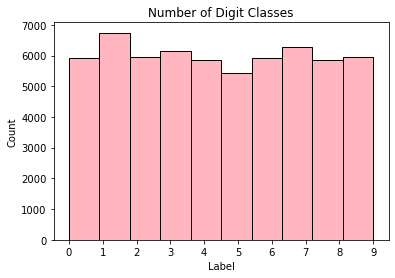

In [145]:
x=np.random.rand(15)
plt.hist(trainlab,edgecolor = "black", color="lightpink")
plt.title("Number of Digit Classes")
plt.xlabel("Label")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Count")
plt.show()

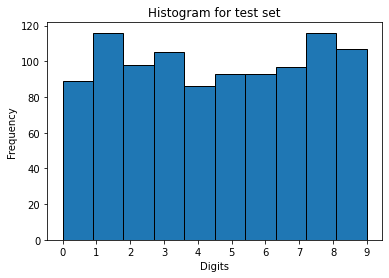

In [110]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))

# # Train
# # sns.countplot((trainlab_samp), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Output label Distribution in Train Set')
# sns.countplot(x='trainlab_samp', data = trainlab_samp)
# # Test
plt.hist(testlab_samp,edgecolor = "black")
plt.title("Histogram for test set")
plt.xlabel("Digits")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Frequency")
plt.show()

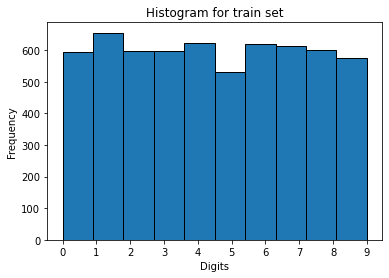

In [111]:
plt.hist(trainlab_samp,edgecolor = "black")
plt.title("Histogram for train set")
plt.xlabel("Digits")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Frequency")
plt.show()

The Histogram for train and test sets are pretty much in line suggesting a balanced dataset

### Model a : Basic MLP Model


Defining the basic MLP models structure with 784 inputs and 10 outputs. Using LeakyReLU as an activation function. Setting dropout to 0.5 and number of hidden layers to 120

In [112]:
#defining the mlp model
class MultilayerPerceptron(nn.Module):
    def __init__(self,num_units=120,nonlin=F.relu,drop=.5):
        super(MultilayerPerceptron,self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(784,num_units), #setting input - 784, hidden layes as - 120
            nn.LeakyReLU(),#leakyRelu as an activation function
            nn.Dropout(p=drop), #drop rate = 0.5
            nn.Linear(num_units,10), #setting output - 10
        )
        
    def forward(self,X):
        X = self.module(X)
        return X

In [113]:
#setting the device type
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)  

cpu


In [114]:
#printing the model
model = MultilayerPerceptron()
print(model)

MultilayerPerceptron(
  (module): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=120, out_features=10, bias=True)
  )
)


Neural Net is wrapped into the skorch classifier. We set the max epoch to 1000, learning rate to 0.1, device to cpu, loss criteria to cross entropy loss, optimizer learning rate to 0.005, optimizer weight decay to 0.01 and using Adam optimizer. Early stopping criteria implemented to prevent over fitting

In [115]:
#defining the neural model with early stopping, optimizer and loss function
torch.manual_seed(0)

net = NeuralNetClassifier(
    MultilayerPerceptron(num_units = 120),
    max_epochs=1000, #maximum epoch
    lr=0.1, #learning rate
    device=device, #device = cpu
    callbacks=[EarlyStopping()], #early stopping criteria used
    criterion=nn.CrossEntropyLoss, #loss function
    optimizer=torch.optim.Adam, #optimizer type
    optimizer__lr = .005, #optimizer learning rate
    optimizer__weight_decay=0.01, #optimizer weight decay
)

In [116]:
#the basic mlp model without hyper parameter tuning 
mlp_basic = net.fit(train_samp.float(),trainlab_samp.long()) #fitting and saving model into search variable
# print(mlp_basic.best_score_,mlp_basic.best_params_) #getting best paramters and best score

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        8.5695       0.7592        0.9333  0.4512
      2        1.6025       0.8067        0.7155  0.2954
      3        1.2250       0.8283        0.5974  0.3345
      4        1.0880       0.8467        0.5389  0.4200
      5        0.9393       0.8492        0.5555  0.2982
      6        0.8296       0.8675        0.5101  0.3858
      7        0.8260       0.8775        0.5459  0.3758
      8        0.8640       0.8625        0.5085  0.4244
      9        0.8189       0.8892        0.4468  0.2691
     10        0.8016       0.8842        0.5282  0.2920
     11        0.8650       0.8750        0.4668  0.2701
     12        0.8526       0.8642        0.4829  0.2772
     13        0.8951       0.8725        0.4982  0.3251
Stopping since valid_loss has not improved in the last 5 epochs.


In [117]:
mlp_basic_grid_predictions = mlp_basic.predict(test_samp.float()) #predicting value

mlp_basic_grid_matrix = confusion_matrix(testlab_samp,mlp_basic_grid_predictions) #getting confusion matrix for basic mlp model
print (mlp_basic_grid_matrix)
# print classification report
print(classification_report(testlab_samp, mlp_basic_grid_predictions))

#performance evaluation of basic mlp model
from sklearn.metrics import precision_recall_fscore_support
score_mlp_grid = precision_recall_fscore_support(testlab_samp, mlp_basic_grid_predictions, average='macro')

accuracy_score_mlp_grid = accuracy_score(testlab_samp, mlp_basic_grid_predictions) #printing accuracy
print ("Accuracy: %.10f" % accuracy_score_mlp_grid)

print("Training set score for MLP: %f" % mlp_basic.score(train_samp.float(), trainlab_samp.long()))
print("Testing  set score for MLP: %f" % mlp_basic.score(test_samp.float(), testlab_samp.long()))

[[ 88   0   0   0   0   0   1   0   0   0]
 [  0 111   0   0   0   0   1   0   4   0]
 [  7   0  83   0   1   0   1   2   4   0]
 [  3   0   2  80   0   0   1   2  14   3]
 [  1   0   0   0  68   0   2   1   1  13]
 [  7   0   0   4   1  73   1   1   5   1]
 [  7   1   0   0   1   0  82   0   1   1]
 [  1   2   1   0   0   0   0  89   2   2]
 [  2   0   2   2   1   1   0   0  96  12]
 [  1   1   0   0   2   0   0   3   2  98]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85        89
           1       0.97      0.96      0.96       116
           2       0.94      0.85      0.89        98
           3       0.93      0.76      0.84       105
           4       0.92      0.79      0.85        86
           5       0.99      0.78      0.87        93
           6       0.92      0.88      0.90        93
           7       0.91      0.92      0.91        97
           8       0.74      0.83      0.78       116
           9       0.75     

In [118]:
# save the model to disk in pickle file
filename = 'mlp_basic.sav'
pickle.dump(mlp_basic, open(filename, 'wb'))

# load the model from disk
mlp_basic = pickle.load(open(filename, 'rb'))

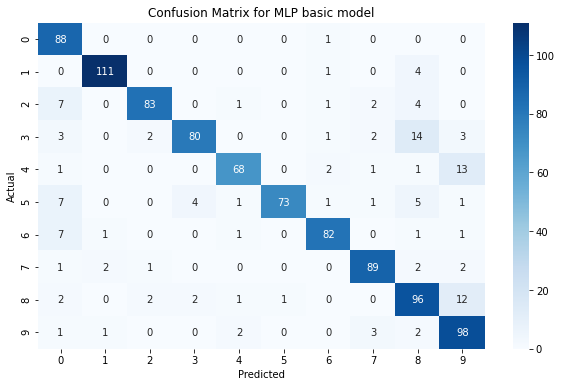

In [119]:
#printing confusion matrix chart for basic mlp model 
cm_mlp = confusion_matrix(testlab_samp, mlp_basic_grid_predictions)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm_mlp, annot = True, fmt = '', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for MLP basic model")
plt.show()

## Hyper-parameter tuning using random search on MLP Model

In [120]:
parameters ={
    'lr':[0.0007,0.0008,0.0009,0.003,0.0020,0.0011,0.001,0.01,0.1,0.05], # learning rate
    'max_epochs':[200,300,350,400,450,500,1000,1500,2000], # max epoch
    'module__num_units':[6,10,15,20,50,100,120,130,150],#no. of hidden layers
    'module__drop' : [0,.1,.2,.3,.4,.0007,.0001,.0004,.004,.007,.01,.0001], #drop rate
    'optimizer': [torch.optim.SGD, torch.optim.Adam],#optimizer type 
}
start_time = time.time()

rs = RandomizedSearchCV(net,parameters,cv=5,scoring='accuracy',refit = 'accuracy') #calling random search
search = rs.fit(train_samp.float(),trainlab_samp.long()) #fitting and saving model into search variable
End_time = time.time()
total_time=End_time-start_time
print(search.best_score_,search.best_params_,total_time) #getting best paramters and best score


Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        5.3316       0.6021        1.3428  0.1935
      2        1.0508       0.7927        0.8503  0.2228
      3        0.7806       0.8208        0.7298  0.1916
      4        0.6332       0.8500        0.6823  0.1790
      5        0.5516       0.8625        0.5688  0.1999
      6        0.5170       0.8729        0.5695  0.2000
      7        0.4426       0.8844        0.5005  0.2410
      8        0.4300       0.8802        0.4896  0.2190
      9        0.3939       0.8927        0.5768  0.2326
     10        0.3799       0.9010        0.5090  0.2463
     11        0.3626       0.9000        0.4671  0.2354
     12        0.3488       0.8979        0.4571  0.2035
     13        0.3258       0.

In [121]:
# save the model to disk in pickle file
filename = 'mlpgrid.sav'
pickle.dump(search, open(filename, 'wb'))

# load the model from disk
search = pickle.load(open(filename, 'rb'))

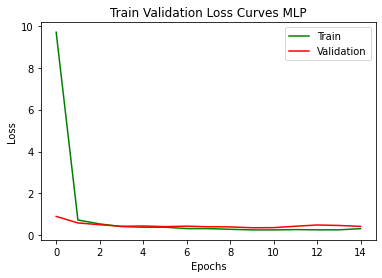

In [122]:
#getting values for train and validation loss
train_loss = search.best_estimator_.history[:,'train_loss']
valid_loss = search.best_estimator_.history[:,'valid_loss']

epochs = [i for i in range(len(search.best_estimator_.history))] #getting total number of epochs
plt.plot(epochs,train_loss,'g-'); #train loss
plt.plot(epochs,valid_loss,'r-'); #validation loss


plt.title('Train Validation Loss Curves MLP');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend(['Train','Validation']);

In [123]:
mlp_grid_predictions = search.predict(test_samp.float()) #predicting value

mlp_grid_matrix = confusion_matrix(testlab_samp,mlp_grid_predictions)
print (mlp_grid_matrix)
# print classification report
print(classification_report(testlab_samp, mlp_grid_predictions))

#performance evalution of a tuned model
from sklearn.metrics import precision_recall_fscore_support
score_mlp_grid = precision_recall_fscore_support(testlab_samp, mlp_grid_predictions, average='macro')

accuracy_score_mlp_grid = accuracy_score(testlab_samp, mlp_grid_predictions)#calculating accuracy
print ("Accuracy: %.10f" % accuracy_score_mlp_grid)

print("Training set score for MLP: %f" % search.score(train_samp.float(), trainlab_samp.long()))
print("Testing  set score for MLP: %f" % search.score(test_samp.float(), testlab_samp.long()))

[[ 88   0   0   1   0   0   0   0   0   0]
 [  0 112   0   0   1   0   1   1   1   0]
 [  2   0  90   2   0   0   0   3   1   0]
 [  0   0   5  92   1   0   1   0   3   3]
 [  2   0   0   0  75   0   0   1   0   8]
 [  2   0   1  12   0  73   1   0   2   2]
 [  4   0   1   0   1   1  86   0   0   0]
 [  0   2   3   0   0   0   0  87   0   5]
 [  1   0   0   3   1   6   0   0  99   6]
 [  1   1   2   0   2   0   0   0   0 101]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        89
           1       0.97      0.97      0.97       116
           2       0.88      0.92      0.90        98
           3       0.84      0.88      0.86       105
           4       0.93      0.87      0.90        86
           5       0.91      0.78      0.84        93
           6       0.97      0.92      0.95        93
           7       0.95      0.90      0.92        97
           8       0.93      0.85      0.89       116
           9       0.81     

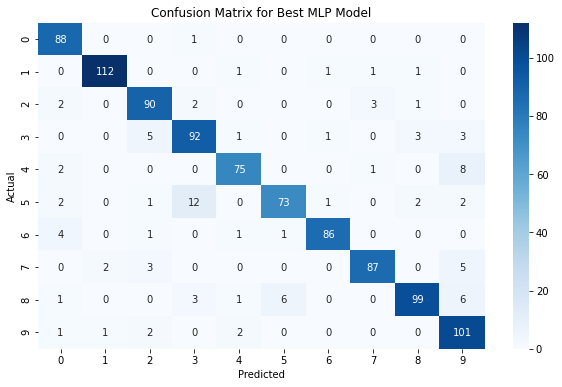

In [146]:
#confusion matrix chart for tuned MLP model
cm_mlp = confusion_matrix(testlab_samp, mlp_grid_predictions)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm_mlp, annot = True, fmt = '', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Best MLP Model")
plt.show()

In [125]:
pd.DataFrame(search.cv_results_) #creating pandas dataframe for storing the mlp tuned results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_units,param_module__drop,param_max_epochs,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.364320,1.216276,0.037353,0.006799,<class 'torch.optim.adam.Adam'>,20,0.0001,500,0.0007,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.873333,0.880833,0.875000,0.890000,0.892500,0.882333,0.007735,6
1,3.160413,1.142426,0.041040,0.011634,<class 'torch.optim.adam.Adam'>,150,0.004,300,0.05,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.905833,0.895833,0.875833,0.896667,0.906667,0.896167,0.011113,2
2,4.344980,0.758330,0.039125,0.006698,<class 'torch.optim.adam.Adam'>,10,0.004,300,0.0008,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.880000,0.890833,0.867500,0.860000,0.875000,0.874667,0.010549,7
3,7.782645,0.647026,0.039386,0.005941,<class 'torch.optim.sgd.SGD'>,20,0.3,500,0.0009,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",0.815833,0.860000,0.857500,0.858333,0.865000,0.851333,0.017940,10
4,8.349624,2.754290,0.046537,0.006834,<class 'torch.optim.sgd.SGD'>,20,0.004,350,0.05,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",0.880000,0.882500,0.861667,0.858333,0.880833,0.872667,0.010427,8
5,4.868986,0.939587,0.036836,0.004983,<class 'torch.optim.adam.Adam'>,15,0.0004,300,0.003,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.885000,0.890000,0.873333,0.875000,0.891667,0.883000,0.007557,5
6,4.083391,1.254627,0.045844,0.007892,<class 'torch.optim.adam.Adam'>,120,0.004,350,0.003,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.893333,0.892500,0.882500,0.905833,0.891667,0.893167,0.007442,3
7,9.212873,4.608454,0.041296,0.009771,<class 'torch.optim.sgd.SGD'>,10,0.0001,2000,0.0011,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",0.850833,0.823333,0.860833,0.864167,0.875833,0.855000,0.017733,9
8,3.875960,0.358465,0.048714,0.007936,<class 'torch.optim.adam.Adam'>,150,0.1,500,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.903333,0.911667,0.895000,0.905000,0.905833,0.904167,0.005375,1
9,5.833583,1.339169,0.048596,0.008925,<class 'torch.optim.sgd.SGD'>,150,0.1,300,0.0009,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",0.905000,0.877500,0.876667,0.869167,0.903333,0.886333,0.014857,4


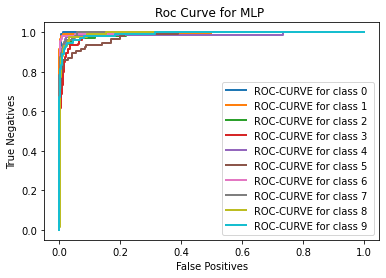

In [159]:
#roc curve for tuned mlp model 
probs1 = search.predict_proba(test_samp.float())
y_conv = label_binarize(testlab_samp.long(), classes=list(range(10))) #to convert output class of test data into binary

fpr = dict() #false positive
tpr = dict() #true positive
roc_auc = dict() #roc value
labels = []
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_conv[:, i], probs1[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0}'.format(i))
    labels.append('ROC-CURVE for class {} '.format(i))

plt.title('Roc Curve for MLP ')
plt.xlabel('False Positives')
plt.ylabel('True Negatives')
plt.legend(labels)
plt.show()

## Model 2 : SVM

In [127]:
svm_basic = svm.SVC(kernel='linear') #svm model with linear classifier
svm_basic.fit(train_samp, trainlab_samp) #fitting the model

SVC(kernel='linear')

In [128]:
# save the model to disk in pickle file
filename = 'svm_basic.sav'
pickle.dump(svm_basic, open(filename, 'wb'))


# load the model from disk
svm_basic = pickle.load(open(filename, 'rb'))

In [129]:
pred_svm_basic = svm_basic.predict(test_samp) #predicting with test data

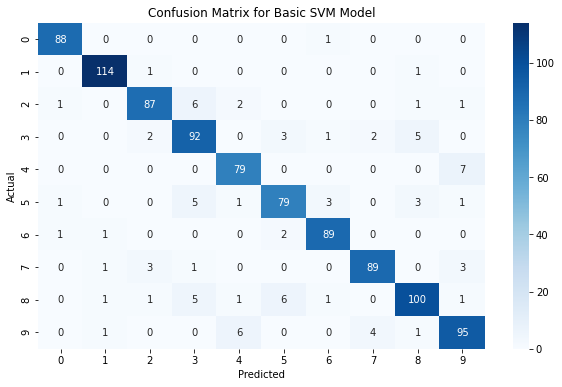

In [147]:
#confusion matrix for basic svm model
cm = confusion_matrix(testlab_samp, pred_svm_basic)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = '', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Basic SVM Model")
plt.show()

Performance metrices for basic svm model

In [131]:
accuracy_score(testlab_samp, pred_svm_basic) # Accuracy

0.912

In [132]:
precision_score(testlab_samp, pred_svm_basic,average='macro') #precision

0.9122336242362371

In [133]:
recall_score(testlab_samp, pred_svm_basic,average='macro') #recall

0.9127969713933621

In [134]:
#printing the classification report for basic svm model
from sklearn.metrics import classification_report
print(classification_report(testlab_samp,pred_svm_basic))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        89
           1       0.97      0.98      0.97       116
           2       0.93      0.89      0.91        98
           3       0.84      0.88      0.86       105
           4       0.89      0.92      0.90        86
           5       0.88      0.85      0.86        93
           6       0.94      0.96      0.95        93
           7       0.94      0.92      0.93        97
           8       0.90      0.86      0.88       116
           9       0.88      0.89      0.88       107

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



## Randomsearch on SVM Model

In [135]:
# defining parameter range
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
               {'kernel':['poly'],'C': [1, 10, 100, 1000], 'degree':[3,4,2], 'gamma': [1e-3, 1e-4]}]

In [136]:
import pickle
print (pickle.format_version)

4.0


In [137]:
#using Accuracy-Score as a scoring parameter for random search
start_time = time.time()
svmgrid = RandomizedSearchCV(svm.SVC(), params_grid, cv=5, scoring = 'accuracy', refit='accuracy_score', n_jobs=1)

#fitting the model
svmgrid.fit(train_samp, trainlab_samp)

End_time = time.time()
total_time=End_time-start_time

#printing best parameters and score
print(svmgrid.best_score_,svmgrid.best_params_,total_time)

0.9531666666666666 {'kernel': 'poly', 'gamma': 0.0001, 'degree': 2, 'C': 1} 186.3627257347107


In [138]:
# save the model to disk in pickle file
filename = 'svmgrid.sav'
pickle.dump(svmgrid, open(filename, 'wb'))

# load the model from disk
svmgrid = pickle.load(open(filename, 'rb'))

In [10]:
#building on best params obtained
from sklearn import svm
svm_best = svm.SVC(kernel='poly',C=1,gamma=0.001,degree=2,probability=True)
svm_best.fit(train_samp, trainlab_samp)

SVC(C=1, degree=2, gamma=0.001, kernel='poly', probability=True)

In [140]:
grid_predictions = svm_best.predict(test_samp) #predicting the values using test set on tuned svm model

grid_matrix = confusion_matrix(testlab_samp,grid_predictions)
print (grid_matrix)
# print classification report
print(classification_report(testlab_samp, grid_predictions))

#performance evalution 
from sklearn.metrics import precision_recall_fscore_support
score_SVM_grid = precision_recall_fscore_support(testlab_samp, grid_predictions, average='macro')

accuracy_score_SVM_grid = accuracy_score(testlab_samp, grid_predictions)#calculating accuracy on tuned model of svm
print ("Accuracy: %.10f" % accuracy_score_SVM_grid)#printing accuracy

print("Training set score for SVM: %f" % svmgrid.score(train_samp, trainlab_samp))
print("Testing  set score for SVM: %f" % svmgrid.score(test_samp, testlab_samp))

[[ 87   0   0   0   0   0   1   0   0   1]
 [  0 115   0   0   0   0   1   0   0   0]
 [  3   0  92   1   0   0   0   1   1   0]
 [  0   0   1 100   0   0   0   0   4   0]
 [  0   1   0   0  81   0   0   0   0   4]
 [  1   0   0   2   1  87   1   0   1   0]
 [  1   1   0   0   0   1  90   0   0   0]
 [  0   1   1   0   0   0   0  92   0   3]
 [  0   0   0   2   0   3   0   0 110   1]
 [  0   2   1   0   4   0   0   1   0  99]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        89
           1       0.96      0.99      0.97       116
           2       0.97      0.94      0.95        98
           3       0.95      0.95      0.95       105
           4       0.94      0.94      0.94        86
           5       0.96      0.94      0.95        93
           6       0.97      0.97      0.97        93
           7       0.98      0.95      0.96        97
           8       0.95      0.95      0.95       116
           9       0.92     

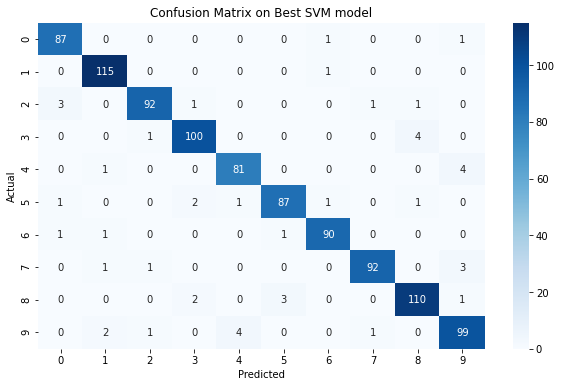

In [148]:
#confusion chart on svm tuned model
cm = confusion_matrix(testlab_samp, grid_predictions)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = '', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Best SVM model")
plt.show()

In [142]:
pd.DataFrame(svmgrid.cv_results_)#storing results of tuned model in a dataframe

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_degree,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.629687,0.034006,0.889590,0.058260,poly,0.0001,2,1,"{'kernel': 'poly', 'gamma': 0.0001, 'degree': ...",0.951667,0.954167,0.951667,0.953333,0.955000,0.953167,0.001333,1
1,3.033010,0.114866,0.765357,0.013673,poly,0.001,3,10,"{'kernel': 'poly', 'gamma': 0.001, 'degree': 3...",0.942500,0.952500,0.945000,0.953333,0.951667,0.949000,0.004391,4
2,2.956658,0.107167,0.768695,0.019383,poly,0.001,3,1,"{'kernel': 'poly', 'gamma': 0.001, 'degree': 3...",0.942500,0.952500,0.945000,0.953333,0.951667,0.949000,0.004391,4
3,3.052217,0.139710,0.820916,0.058029,poly,0.0001,3,100,"{'kernel': 'poly', 'gamma': 0.0001, 'degree': ...",0.942500,0.952500,0.945000,0.953333,0.951667,0.949000,0.004391,4
4,3.292726,0.034903,0.786300,0.074864,poly,0.001,4,10,"{'kernel': 'poly', 'gamma': 0.001, 'degree': 4...",0.928333,0.936667,0.927500,0.939167,0.937500,0.933833,0.004905,7
5,2.706027,0.102436,0.834688,0.011878,poly,0.001,2,1,"{'kernel': 'poly', 'gamma': 0.001, 'degree': 2...",0.951667,0.954167,0.951667,0.953333,0.955000,0.953167,0.001333,1
6,2.290596,0.103977,0.864820,0.037586,linear,NaN,NaN,1,"{'kernel': 'linear', 'C': 1}",0.920000,0.905000,0.911667,0.906667,0.925833,0.913833,0.007951,9
7,3.366976,0.088405,0.755003,0.010570,poly,0.001,4,1,"{'kernel': 'poly', 'gamma': 0.001, 'degree': 4...",0.928333,0.936667,0.927500,0.939167,0.937500,0.933833,0.004905,7
8,2.257899,0.113150,0.845112,0.023626,linear,NaN,NaN,1000,"{'kernel': 'linear', 'C': 1000}",0.920000,0.905000,0.911667,0.906667,0.925833,0.913833,0.007951,9
9,2.707671,0.125463,0.838781,0.013780,poly,0.0001,2,1000,"{'kernel': 'poly', 'gamma': 0.0001, 'degree': ...",0.951667,0.954167,0.951667,0.953333,0.955000,0.953167,0.001333,1


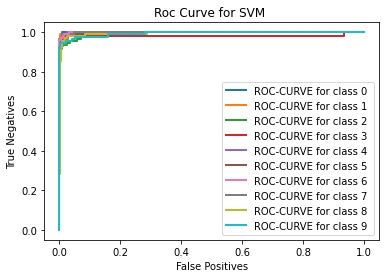

In [11]:
#roc curve on tuned model of SVM
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = svm_best.predict_proba(test_samp)
y_conv = label_binarize(testlab_samp, classes=list(range(10))) #to convert output class of test data into binary

fpr = dict() #false positive
tpr = dict() #true positive
roc_auc = dict() #roc value
labels = []
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_conv[:, i], probs[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0}'.format(i))
    labels.append('ROC-CURVE for class {} '.format(i))

plt.title('Roc Curve for SVM ')
plt.xlabel('False Positives')
plt.ylabel('True Negatives')
plt.legend(labels)
plt.show()


In [12]:
#calculating auc-roc value
macro_roc_auc_ovo = roc_auc_score(testlab_samp, probs, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(testlab_samp, probs, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(testlab_samp, probs, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(testlab_samp, probs, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.995718 (macro),
0.995716 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.995709 (macro),
0.995718 (weighted by prevalence)
